In [ ]:
!pip install acoular

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/beamforming-gh/LICENSE
/kaggle/input/beamforming-gh/.gitignore
/kaggle/input/beamforming-gh/pyproject.toml
/kaggle/input/beamforming-gh/README.md
/kaggle/input/beamforming-gh/uv.lock
/kaggle/input/beamforming-gh/beamforming-acoular.ipynb
/kaggle/input/beamforming-gh/beamforming.py
/kaggle/input/beamforming-gh/.python-version
/kaggle/input/beamforming-gh/drone+diesel.h5
/kaggle/input/beamforming-gh/sounds/wind_noise_44100_1s.wav
/kaggle/input/beamforming-gh/sounds/B_S2_D1_067-bebop_000_cleaned.wav
/kaggle/input/beamforming-gh/sounds/diesel_engine_16bit_44100_1s_0db.wav
/kaggle/input/beamforming-gh/geo/3_by_3.xml
/kaggle/input/beamforming-gh/geo/4_mic.xml


In [12]:
from pathlib import Path
import os
import librosa as lb
import acoular as ac
import numpy as np
import scipy as sp
from pylab import axis, colorbar, figure, imshow, plot, show

In [17]:
# Available paths

TMP_DIR = Path('../temp')
TMP_DIR.mkdir(exist_ok=True)

In [18]:
ls ../

input/  lib/  temp/  working/


/kaggle/input/beamforming-gh/geo/3_by_3.xml
2
22050


/usr/local/lib/python3.11/dist-packages/acoular/signals.py:121: Warning: Signal source has more than one channel. Only channel 0 will be used for signal.
  return resample(self.signal(), factor * self.num_samples)
/tmp/ipykernel_31/2795921793.py:71: DeprecationWarning: Deprecated use of 'name' trait. Please use the 'file' trait instead.
  ts = ac.TimeSamples(name=datafile)


[('drone+diesel_cache.h5', 9)]


/tmp/ipykernel_31/2795921793.py:95: DeprecationWarning: Deprecated use of 'mpos' trait. Please use the 'pos' trait instead.
  plot(mg.mpos[0], mg.mpos[1], 'o')


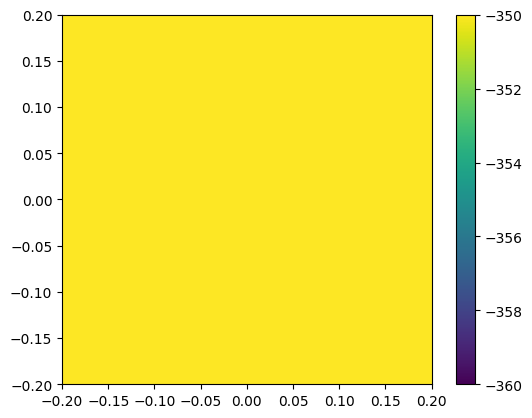

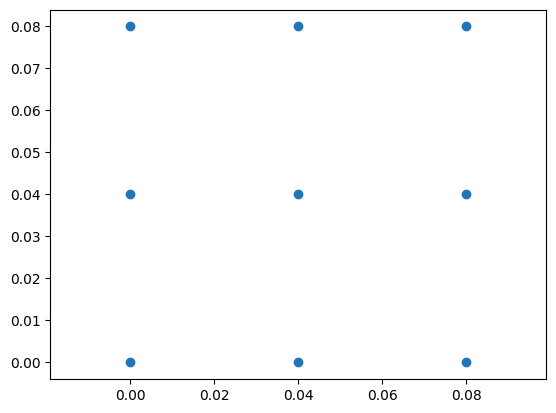

In [35]:
# ------------------------------------------------------------------------------
# Copyright (c) Acoular Development Team.
# ------------------------------------------------------------------------------
"""
Basic Beamforming -- Generate a map of three sources.
=====================================================

Loads the simulated signals from the `three_sources.h5` file, analyzes them with Conventional Beamforming
and generates a map of the three sources.

.. note:: The `three_sources.h5` file must be generated first by running the :doc:`example_three_sources` example.
"""
h5path = '/kaggle/temp/drone+diesel.h5'
kaggle_input_path = '/kaggle/input/beamforming-gh/'

os.remove(h5path)

def synth_pressure():
    sfreq = 22050
    duration = 1
    nsamples = duration * sfreq
    micgeofile = os.path.join(kaggle_input_path, 'geo/3_by_3.xml')

    print(micgeofile)
    
    h5savefile = Path(h5path)

    m = ac.MicGeom(file=micgeofile)
    n1 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=nsamples, seed=1, rms=0.5)
    #n2 = ac.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=2, rms=0.5)
    #n3 = ac.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=3, rms=0.5)
    p1 = ac.PointSource(signal=n1, mics=m, loc=(0, 1, 10000))
    #p2 = ac.PointSource(signal=n2, mics=m, loc=(0.15, 0, 2))
    #p3 = ac.PointSource(signal=n3, mics=m, loc=(0, 0.1, 3))

    drone_file = Path(f'{kaggle_input_path}/sounds/B_S2_D1_067-bebop_000_cleaned.wav')
    assert drone_file.exists(), 'Drone file not found, run example_three_sources.py first'

    # diesel_file = Path('sounds/diesel_engine_16bit_44100_1s_0db.wav')
    # assert diesel_file.exists(), 'Diesel file not found, run example_three_sources.py first'

    drone_data, drone_sr = lb.load(drone_file)
    #diesel_data, diesel_sr = lb.load('diesel_engine_16bit_44100_1s_0db.mp3')

    drone_data = drone_data.reshape(1,-1)

    print(drone_data.ndim)
    print(drone_sr)

    drone_ts = ac.TimeSamples(data=drone_data, sample_freq=drone_sr)
    #diesel_ts = ac.TimeSamples(data=diesel_data, numsamples=diesel_sr)

    drone_generator = ac.GenericSignalGenerator(source=drone_ts)

    drone_ps = ac.PointSource(signal=drone_generator, mics=m, loc=(0, 1, 40))
    #diesel_ps = ac.PointSource(signal=diesel_ts, mics=m, loc=(-1, -1, 1))

    p = ac.Mixer(source=drone_ps)

    wh5 = ac.WriteH5(source=p, file=h5savefile)
    wh5.save()    

synth_pressure()

micgeofile = os.path.join(kaggle_input_path, 'geo/3_by_3.xml')
datafile = Path(h5path)
assert datafile.exists(), 'Data file not found, run example_three_sources.py first'

mg = ac.MicGeom(file=micgeofile)

ts = ac.TimeSamples(name=datafile)

ps = ac.PowerSpectra(source=ts, block_size=128, window='Hanning')

rg = ac.RectGrid(x_min=-0.2, x_max=0.2, y_min=-0.2, y_max=0.2, z=0.3, increment=0.01)

st = ac.SteeringVector(grid=rg, mics=mg)

bb = ac.BeamformerFunctional(freq_data=ps, steer=st)

pm = bb.synthetic(5000, 20)

Lm = ac.L_p(pm)

# Calculate distance using time differences
# delays = np.angle(st) / (2 * np.pi * ps.fftfreq()[1])
# distances = delays * 343.2  # Speed of sound in m/s

# Average distance across all microphones
# mean_distance = np.mean(np.abs(distances))

imshow(Lm.T, origin='lower', vmin=Lm.max() - 10, extent=rg.extend(), interpolation='bicubic')
colorbar()
figure(2)
plot(mg.mpos[0], mg.mpos[1], 'o')
axis('equal')
show()